# Apendix

## Part1

### (a) 
Compute the eigenvalues and eigenvectors of A.

In [1]:
import numpy as np

# Define the system matrix for h1(t) and h2(t)
A = np.array([[-1, 0],
              [0, -10]])

# Compute eigenvalues and eigenvectors of the matrix A
eigenvalues, eigenvectors = np.linalg.eig(A)

eigenvalues, eigenvectors

(array([ -1., -10.]),
 array([[1., 0.],
        [0., 1.]]))

### (b)
Compute the leading spatial POD mode.

In [2]:
# Constants and parameters for simulation
dt = 1e-3  # Time step
total_time = 1  # Total time of simulation
num_steps = int(total_time / dt)  # Number of time steps
num_trajectories = 1000  # Number of trajectories

# Initial conditions
h_initial = np.zeros((2, 1))

# Discrete-time system matrix
A_discrete = np.eye(2) + A * dt
B_discrete = np.array([[1e-3], [1e3]]) * dt

# To store all trajectories
all_trajectories = np.zeros((2, num_steps, num_trajectories))

# Simulate the system
np.random.seed(42)  # for reproducibility
for j in range(num_trajectories):
    h = h_initial.copy()
    for i in range(num_steps):
        x_t = np.random.normal(0, 1)  # Sample x(t)
        h = A_discrete @ h + B_discrete * x_t  # Euler integration step
        all_trajectories[:, i, j] = h.squeeze()

# Perform POD via time-averaging across all trajectories
data_matrix = all_trajectories.reshape(2, -1)  # Flatten trajectories into a matrix of 2 x (num_steps*num_trajectories)
covariance_matrix = np.cov(data_matrix)  # Compute the covariance matrix
pod_eigenvalues, pod_eigenvectors = np.linalg.eig(covariance_matrix)  # Eigen-decomposition

# Sort eigenvectors based on eigenvalues in descending order
sorted_indices = np.argsort(-pod_eigenvalues)
leading_pod_mode = pod_eigenvectors[:, sorted_indices[0]]

pod_eigenvalues, pod_eigenvectors, leading_pod_mode


(array([1.47942103e-10, 4.80789523e+01]),
 array([[-1.00000000e+00, -1.74345659e-06],
        [ 1.74345659e-06, -1.00000000e+00]]),
 array([-1.74345659e-06, -1.00000000e+00]))

### (h)
Compute the $W_c(t)$ and its eigenvalues.

In [3]:
import numpy as np
from scipy.linalg import expm, eigvals

# Define the system matrices
A = np.array([[-1, 0],
              [0, -10]])
B = np.array([[1e-3],
              [1e3]])

# Time at which to compute the Gramian
t = 1

# Compute the controllability Gramian
# Wc(t) = integral from 0 to t of expm(A*s) * B * B.T * expm(A.T*s) ds
# For numerical computation, we use the matrix exponential at discrete steps

# Discretization parameters
num_steps = 1000
delta_t = t / num_steps
Wc = np.zeros((2, 2))

for step in range(num_steps):
    tau = step * delta_t
    Wc += expm(A * tau) @ B @ B.T @ expm(A.T * tau) * delta_t

# Compute the eigenvalues of the controllability Gramian
eigenvalues = eigvals(Wc)

Wc, eigenvalues

(array([[4.32764835e-07, 9.14084809e-02],
        [9.14084809e-02, 5.05016666e+04]]),
 array([2.67318683e-07+0.j, 5.05016666e+04+0.j]))

### (i)
Compute the $\tilde{A}$ and $\tilde{B}$, then compute the $\tilde{W}_c(1)$.

In [4]:
# Define the transformation matrix T
T = np.array([[1e3, 0],
              [0, 1e-3]])

# Compute the new A and B matrices for the transformed system
A_tilde = T @ A @ np.linalg.inv(T)
B_tilde = T @ B

# Compute the controllability Gramian for the transformed system
Wc_tilde = np.zeros((2, 2))

for step in range(num_steps):
    tau = step * delta_t
    Wc_tilde += expm(A_tilde * tau) @ B_tilde @ B_tilde.T @ expm(A_tilde.T * tau) * delta_t

# Compute the eigenvalues of the controllability Gramian
eigenvalues_tilde = eigvals(Wc_tilde)

Wc_tilde, eigenvalues_tilde

(array([[0.43276483, 0.09140848],
        [0.09140848, 0.05050167]]),
 array([0.45349829+0.j, 0.02976822+0.j]))

## Part2

### Import Libraries and Load Data

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'grouped_tortilla_prices.csv'
data = pd.read_csv(file_path)

# Preview the data
print(data.head())


            State Year-Month  Price per kilogram
0  Aguascalientes    2007-01            7.835882
1  Aguascalientes    2007-02            7.787174
2  Aguascalientes    2007-03            7.698462
3  Aguascalientes    2007-04            7.685000
4  Aguascalientes    2007-05            7.685000


### Preprocess and Apply PCA on the Whole Dataset

In [6]:
# Fill missing values
data['Price per kilogram'].fillna(data['Price per kilogram'].median(), inplace=True)

# Convert 'Year-Month' to datetime format
data['Year-Month'] = pd.to_datetime(data['Year-Month'])

# Pivot the data
pivot_table = data.pivot(index='Year-Month', columns='State', values='Price per kilogram')
pivot_table.fillna(pivot_table.median(), inplace=True)

# Standardizing the data before applying PCA
scaler = StandardScaler()
data_scaled = scaler.fit_transform(pivot_table)

# Applying PCA to retain 95% of the variance
pca = PCA(n_components=0.99)
principal_components = pca.fit_transform(data_scaled)

# Create a DataFrame of the principal components
pca_df = pd.DataFrame(data=principal_components, index=pivot_table.index)

print(pca_df.head(15))

                   0         1         2
Year-Month                              
2007-01-01 -7.953106  0.536096  0.152678
2007-02-01 -8.131120  0.592858  0.249689
2007-03-01 -8.176028  0.550226  0.236347
2007-04-01 -8.162595  0.549773  0.250896
2007-05-01 -8.116555  0.552636  0.272421
2007-06-01 -8.104557  0.551042  0.271980
2007-07-01 -8.096169  0.549248  0.272259
2007-08-01 -8.088563  0.550694  0.277068
2007-09-01 -8.088994  0.549047  0.281739
2007-10-01 -8.088334  0.549679  0.272549
2007-11-01 -8.075939  0.547108  0.266024
2007-12-01 -8.071679  0.560971  0.261951
2008-01-01 -7.984234  0.565846  0.176932
2008-02-01 -7.942506  0.541142  0.175748
2008-03-01 -7.942035  0.544829  0.190182


### Split the Data and Fit the VAR Model

In [7]:
# Split the dimension-reduced dataset into training and testing sets (80% train, 20% test)
train_pca_df, test_pca_df = train_test_split(pca_df, test_size=0.2, random_state=42, shuffle=False)

# Fit the VAR model on the training data
model = VAR(train_pca_df)
results = model.fit(maxlags=5, ic='aic')

# Summary of the VAR model
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 29, Apr, 2024
Time:                     10:45:06
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -13.6112
Nobs:                     162.000    HQIC:                  -14.0527
Log likelihood:           512.110    FPE:                5.83946e-07
AIC:                     -14.3545    Det(Omega_mle):     4.63237e-07
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.184551         0.070416            2.621           0.009
L1.0          0.735341         0.149939            4.904           0.000
L1.1          0.203687         0.503668            0.404           0.686
L1.2         -0.044023 

/Users/huangrui/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Forecast Using the VAR Model

In [8]:
# Forecasting the next steps based on the size of the test set
forecast_steps = len(test_pca_df)
forecasted_values = results.forecast(y=train_pca_df.values[-results.k_ar:], steps=forecast_steps)

# Inverse transform the forecasted principal components back to the original feature space
forecasted_data_scaled = pca.inverse_transform(forecasted_values)
forecasted_data = scaler.inverse_transform(forecasted_data_scaled)

# Create a DataFrame for the forecasted data
forecasted_df = pd.DataFrame(data=forecasted_data, index=test_pca_df.index, columns=pivot_table.columns)

print(forecasted_df.head())

State       Aguascalientes  Baja California  Baja California Sur   Campeche  \
Year-Month                                                                    
2020-11-01       12.272366        15.043422            15.073116  14.380130   
2020-12-01       12.462480        15.321035            15.439606  14.669390   
2021-01-01       12.512127        15.443194            15.645389  15.037627   
2021-02-01       12.511410        15.410043            15.551348  14.925695   
2021-03-01       12.549081        15.467795            15.634803  14.981841   

State         Chiapas  Chihuahua   Coahuila     Colima       D.F.    Durango  \
Year-Month                                                                     
2020-11-01  12.951182  13.619092  14.771393  13.634060  12.771656  12.919616   
2020-12-01  13.220659  13.790612  15.148030  13.835517  13.106906  13.144231   
2021-01-01  13.418118  13.962067  15.360592  13.942852  13.151087  13.285563   
2021-02-01  13.352171  13.966863  15.272084  1

### Visualize and Evaluate the Model

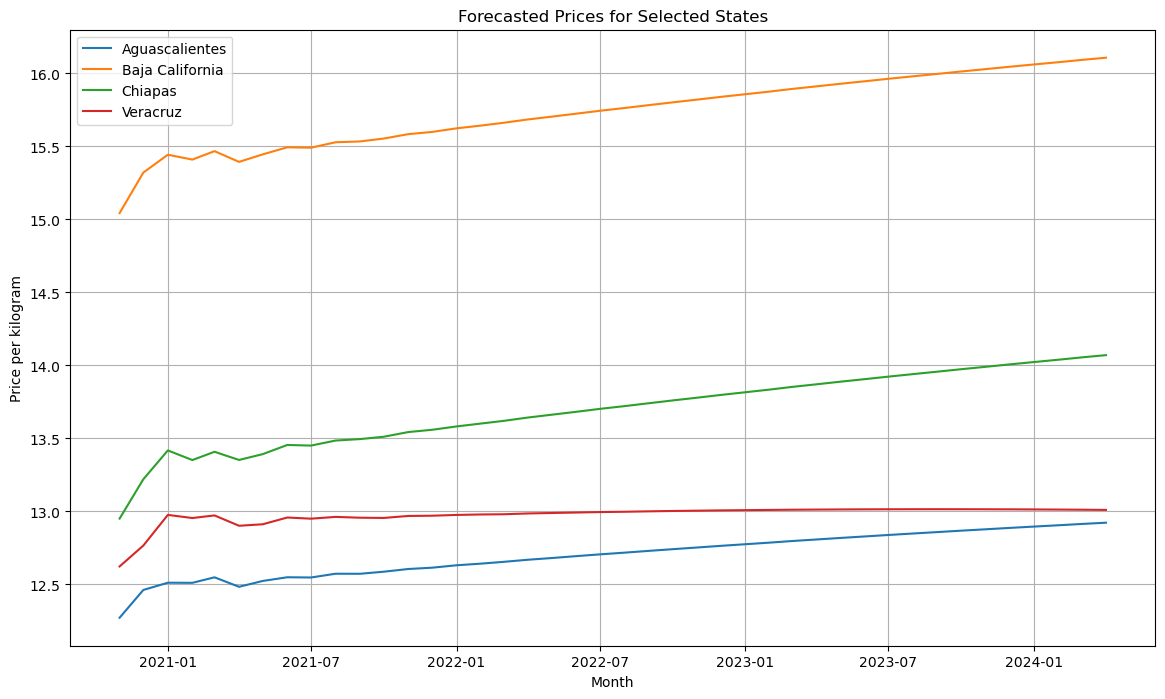

MAE: 2.743260393884601, MSE: 10.399427076313355, RMSE: 3.224814270049262


In [9]:
# Select a few states to visualize
states_to_visualize = ['Aguascalientes', 'Baja\xa0California', 'Chiapas', 'Veracruz']

# Plotting the forecasts for the selected states
plt.figure(figsize=(14, 8))
for state in states_to_visualize:
    plt.plot(forecasted_df.index, forecasted_df[state], label=state)

plt.title('Forecasted Prices for Selected States')
plt.xlabel('Month')
plt.ylabel('Price per kilogram')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the forecasts
true_values = pivot_table.loc[test_pca_df.index]
mae = mean_absolute_error(true_values, forecasted_df)
mse = mean_squared_error(true_values, forecasted_df)
rmse = np.sqrt(mse)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")


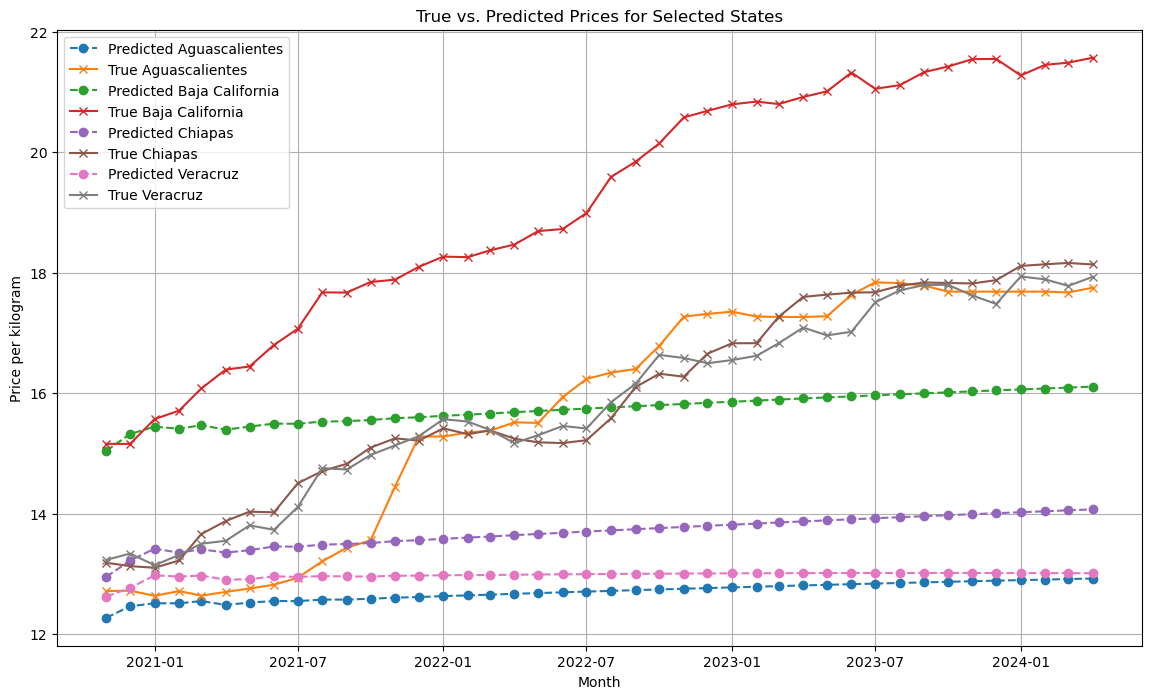

In [10]:
import matplotlib.pyplot as plt

# Select a few states to visualize
states_to_visualize = ['Aguascalientes', 'Baja\xa0California', 'Chiapas', 'Veracruz']

# Ensure the indices of the true values and the forecasted data align properly
true_values = pivot_table.loc[forecasted_df.index]  # Actual data for the same dates

# Plotting the forecasts and actual data for the selected states
plt.figure(figsize=(14, 8))
for state in states_to_visualize:
    plt.plot(forecasted_df.index, forecasted_df[state], label=f'Predicted {state}', marker='o', linestyle='--')
    plt.plot(true_values.index, true_values[state], label=f'True {state}', marker='x', linestyle='-')

plt.title('True vs. Predicted Prices for Selected States')
plt.xlabel('Month')
plt.ylabel('Price per kilogram')
plt.legend()
plt.grid(True)
plt.show()
